# [Product Sentiment Classification Hackathon](https://www.machinehack.com/hackathons/product_sentiment_classification_weekend_hackathon_19)

### Task 1: Import Libraries and Load the Training Data

In [1]:
!nvidia-smi

Mon Sep  7 09:55:12 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!wget https://machinehack-be.s3.amazonaws.com/product_sentiment_classification_weekend_hackathon_19/Participants_Data.zip
!unzip -q Participants_Data.zip

--2020-09-07 09:55:17--  https://machinehack-be.s3.amazonaws.com/product_sentiment_classification_weekend_hackathon_19/Participants_Data.zip
Resolving machinehack-be.s3.amazonaws.com (machinehack-be.s3.amazonaws.com)... 52.219.66.104
Connecting to machinehack-be.s3.amazonaws.com (machinehack-be.s3.amazonaws.com)|52.219.66.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 400578 (391K) [application/zip]
Saving to: ‘Participants_Data.zip’

Participants_Data.z 100%[===================>] 391.19K   333KB/s    in 1.2s    

2020-09-07 09:55:19 (333 KB/s) - ‘Participants_Data.zip’ saved [400578/400578]



In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('/content/Participants_Data/Train.csv', low_memory=False)
df.shape

(6364, 4)

### Task 2: Bare Minimum EDA

In [2]:
df.head()

,Text_ID,Product_Description,Product_Type,Sentiment
0,3057,The Web DesignerÛªs Guide to iOS (and Android...,9,2
1,6254,RT @mention Line for iPad 2 is longer today th...,9,2
2,8212,Crazy that Apple is opening a temporary store ...,9,2
3,4422,The lesson from Google One Pass: In this digit...,9,2
4,5526,RT @mention At the panel: &quot;Your mom has a...,9,2


In [3]:
df.Sentiment.value_counts()

2    3765
3    2089
1     399
0     111
Name: Sentiment, dtype: int64

In [4]:
df.Product_Type.nunique()

10

### Task 3: Define Feature and Target Matrices

In [5]:
ONE_HOT_FEATURES = {
    "Product_Type": 10
}

TEXT_FEATURES = {
    "Product_Description": None
}

In [6]:
def make_one_hot(df):
    one_hot_array = []
    for feature_name in ONE_HOT_FEATURES.keys():
        temp_array = np.asarray(tf.keras.utils.to_categorical(df[feature_name].values))
        ONE_HOT_FEATURES[feature_name] = temp_array.shape[1]
        one_hot_array.append(temp_array)

    return one_hot_array

In [7]:
for feature in ONE_HOT_FEATURES.keys():
    df[feature] = df[feature].astype("category").cat.codes

one_hot_x = make_one_hot(df)

embedding_x = [np.asarray(df[feature_name].values).reshape(-1) for feature_name in TEXT_FEATURES.keys()]

In [8]:
X = one_hot_x + embedding_x
y = np.asarray(df["Sentiment"], dtype=np.uint8).reshape(-1)

### Task 4: Define Basic Hyperparamters

In [9]:
LR = 0.0001
BATCH_SIZE = 32
EPOCHS = 100

### Task 5: Build a Wide and Deep Model (sort of)

Architecture inspired by [Wide & Deep Learning: Better Together with TensorFlow](https://ai.googleblog.com/2016/06/wide-deep-learning-better-together-with.html)

In [10]:
def transformed_name(key):
    return key + '_xf'

def get_model(show_summary=True):
    """
    This function defines a Keras wide and deep model and returns the model as a Keras object.
    """
    
    # adding text input features
    input_texts = []
    for key in TEXT_FEATURES.keys():
        input_texts.append(tf.keras.Input(shape=(1,), name=transformed_name(key), dtype=tf.string))
    
    # adding one-hot encoded features
    input_features = []
    for key, dim in ONE_HOT_FEATURES.items():
        input_features.append(tf.keras.Input(shape=(dim), name=transformed_name(key)))


    # embed text features
    MODULE_URL = "https://tfhub.dev/google/universal-sentence-encoder/4" # almost a gigabyte of weights, yikes!
    embed = hub.KerasLayer(MODULE_URL)
    reshaped_narrative = tf.reshape(input_texts[0], [-1]) # reshape to match hub layer input, i.e., 1 entry per row
    embed_narrative = embed(reshaped_narrative) # outputs 512 dimensional embeddings
    deep_ff = tf.keras.layers.Reshape((512, ), input_shape=(1, 512))(embed_narrative)
    
    deep = tf.keras.layers.Dense(256, activation='relu')(deep_ff) # deep layers for text features
    deep = tf.keras.layers.Dropout(0.2)(deep)
    deep = tf.keras.layers.Dense(128, activation='relu')(deep)
    deep = tf.keras.layers.Dropout(0.1)(deep)
    deep = tf.keras.layers.Dense(64, activation='relu')(deep)
    #deep = tf.keras.layers.Dense(16, activation='relu')(deep)

    wide_ff = input_features[0] # tf.keras.layers.concatenate(input_features) <- use when multiple one-hot features
    wide = tf.keras.layers.Dense(64, activation='relu')(wide_ff) # wide layers for one-hot encoded categoricals
    #wide = tf.keras.layers.Dense(16, activation='relu')(wide)

    both = tf.keras.layers.concatenate([deep, wide])

    output = tf.keras.layers.Dense(4, activation='softmax')(both)

    inputs = input_features + input_texts

    keras_model = tf.keras.models.Model(inputs, output)
    keras_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
                        loss='sparse_categorical_crossentropy',  
                        metrics=['accuracy'])
    if show_summary:
        keras_model.summary()

    return keras_model

In [11]:
model = get_model(show_summary=True)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Product_Description_xf (InputLa [(None, 1)]          0                                            
__________________________________________________________________________________________________
tf_op_layer_Reshape (TensorFlow [(None,)]            0           Product_Description_xf[0][0]     
__________________________________________________________________________________________________
keras_layer (KerasLayer)        (None, 512)          256797824   tf_op_layer_Reshape[0][0]        
__________________________________________________________________________________________________
reshape (Reshape)               (None, 512)          0           keras_layer[0][0]                
_______________________________________________________________________________________

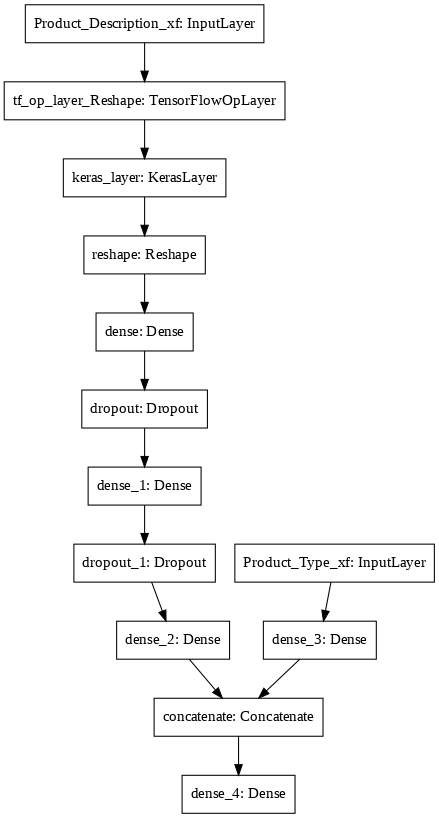

In [12]:
tf.keras.utils.plot_model(model, rankdir='TB', to_file='model.png', dpi=76)

### Task 6: Train Model

In [14]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
#lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
#checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='checkpoints', monitor='val_loss', save_best_only=True, save_weights_only=True)

history = model.fit(x=X, y=y, batch_size=BATCH_SIZE, validation_split=0.1,
                    epochs=EPOCHS, callbacks=[es], verbose=1)

Epoch 1/100
179/179 [==============================] - 2s 12ms/step - loss: 1.0502 - accuracy: 0.5774 - val_loss: 0.8984 - val_accuracy: 0.5620
Epoch 2/100
179/179 [==============================] - 2s 10ms/step - loss: 0.8015 - accuracy: 0.6642 - val_loss: 0.8192 - val_accuracy: 0.6766
Epoch 3/100
179/179 [==============================] - 2s 10ms/step - loss: 0.7234 - accuracy: 0.7636 - val_loss: 0.7481 - val_accuracy: 0.7614
Epoch 4/100
179/179 [==============================] - 2s 10ms/step - loss: 0.6519 - accuracy: 0.8100 - val_loss: 0.6787 - val_accuracy: 0.7928
Epoch 5/100
179/179 [==============================] - 2s 10ms/step - loss: 0.5869 - accuracy: 0.8380 - val_loss: 0.6230 - val_accuracy: 0.8022
Epoch 6/100
179/179 [==============================] - 2s 10ms/step - loss: 0.5333 - accuracy: 0.8554 - val_loss: 0.5695 - val_accuracy: 0.8446
Epoch 7/100
179/179 [==============================] - 2s 10ms/step - loss: 0.4863 - accuracy: 0.8729 - val_loss: 0.5352 - val_accuracy:

### Task 7: Retrain Model

In [ ]:
#model.load_weights('/content/checkpoints.index')

In [18]:
del model
model = get_model(show_summary=False)

In [19]:
model.fit(x=X, y=y, epochs=8, verbose=1, batch_size=BATCH_SIZE) # retrain on the complete dataset for num_epochs with the lowest val_loss

Epoch 1/8
199/199 [==============================] - 2s 9ms/step - loss: 1.0560 - accuracy: 0.5475
Epoch 2/8
199/199 [==============================] - 2s 9ms/step - loss: 0.8031 - accuracy: 0.6796
Epoch 3/8
199/199 [==============================] - 2s 9ms/step - loss: 0.7209 - accuracy: 0.7599
Epoch 4/8
199/199 [==============================] - 2s 9ms/step - loss: 0.6418 - accuracy: 0.8075
Epoch 5/8
199/199 [==============================] - 2s 9ms/step - loss: 0.5749 - accuracy: 0.8347
Epoch 6/8
199/199 [==============================] - 2s 9ms/step - loss: 0.5180 - accuracy: 0.8553
Epoch 7/8
199/199 [==============================] - 2s 9ms/step - loss: 0.4710 - accuracy: 0.8727
Epoch 8/8
199/199 [==============================] - 2s 9ms/step - loss: 0.4350 - accuracy: 0.8837


### Task 8: Test Data Pipeline

In [20]:
test_df = pd.read_csv('/content/Participants_Data/Test.csv', low_memory=False)

ONE_HOT_FEATURES = {
    "Product_Type": 10
}
TEXT_FEATURES = {
    "Product_Description": None
}

for feature in ONE_HOT_FEATURES.keys():
    test_df[feature] = test_df[feature].astype("category").cat.codes

one_hot_x = make_one_hot(test_df)

embedding_x = [np.asarray(test_df[feature_name].values).reshape(-1) for feature_name in TEXT_FEATURES.keys()]
X = one_hot_x + embedding_x

### Task 9: Model Inference on Test Data

In [21]:
preds = model.predict(X)

In [22]:
preds

array([[8.5031018e-03, 4.5976542e-02, 1.9261777e-01, 7.5290257e-01],
       [6.2352128e-02, 1.6220716e-01, 6.6587383e-01, 1.0956693e-01],
       [6.8597190e-02, 1.5369940e-01, 6.1153215e-01, 1.6617124e-01],
       ...,
       [2.7805425e-03, 9.2547499e-03, 6.1136659e-02, 9.2682809e-01],
       [1.4902602e-03, 8.8806869e-04, 9.3969548e-01, 5.7926159e-02],
       [4.7780290e-02, 2.9234186e-01, 1.2856685e-01, 5.3131098e-01]],
      dtype=float32)

In [23]:
pd.DataFrame(preds, columns=['0', '1', '2', '3']).to_csv('sub.csv', index=False)